In [53]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import yfinance as yf

from datetime import datetime
import itertools as it
from math import sqrt
from sklearn import metrics

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore")

import wrangle

In [54]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-dark-palette')
plt.rc('font', size=16)

In [55]:
# use a function to pull in data
nem, holo, nem_hr, holo_hr = wrangle.get_crypto_data()
nem.shape, holo.shape, nem_hr.shape, holo_hr.shape

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


((1535, 6), (1363, 6), (1091, 6), (1091, 6))

In [56]:
# use a function to split data for NEM
nem_train, nem_validate, nem_test = wrangle.split_time_series_data(nem)
nem_train.shape, nem_validate.shape, nem_test.shape

((767, 6), (460, 6), (308, 6))

In [57]:
# drop columns that will not be used in the prediction
nem_train, nem_validate, nem_test = pd.DataFrame(nem_train['Close']),\
                                    pd.DataFrame(nem_validate['Close']),\
                                    pd.DataFrame(nem_test['Close'])

In [58]:
# use a function to split data for HOLO
holo_train, holo_validate, holo_test = wrangle.split_time_series_data(holo)
holo_train.shape, holo_validate.shape, holo_test.shape

((681, 6), (408, 6), (274, 6))

In [59]:
# drop columns that will not be used in the prediction
holo_train, holo_validate, holo_test = pd.DataFrame(holo_train['Close']),\
                                    pd.DataFrame(holo_validate['Close']),\
                                    pd.DataFrame(holo_test['Close'])

In [60]:
# compute rmse to evaluate model
def evaluate(validate_set, target_var):
    rmse = round(sqrt(metrics.mean_squared_error(validate_set[target_var], yhat_df[target_var])), 5)
    return rmse


# plot original and predicted values
def plot_and_eval(train_set, validate_set, target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train_set[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate_set[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var], label = 'Prediction', linewidth = 1)
    plt.title(target_var)
    plt.legend()
    rmse = evaluate(validate_set, target_var)
    print(f'{target_var} -- RMSE: {rmse}')
    plt.show()
    

# create df object to append to
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# append evaluations to a df for comparison
def append_eval_df(model_type, validate_set, target_var):
    rmse = evaluate(validate_set, target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### Establish a baseline model

<AxesSubplot:xlabel='Date'>

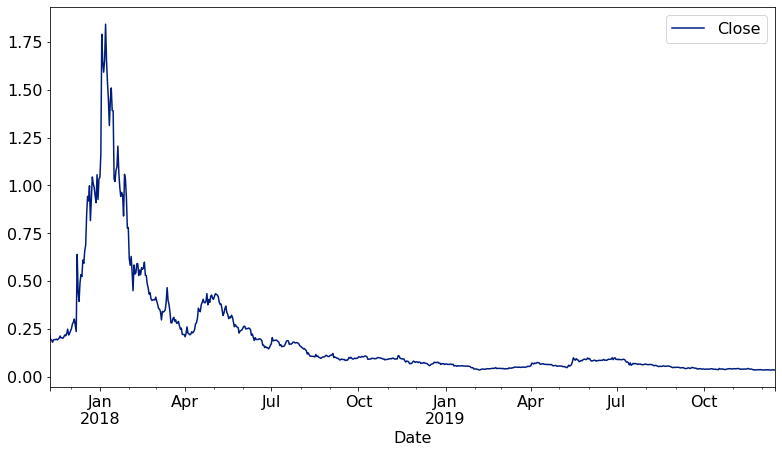

In [61]:
# plot data
nem_train.plot()

**For NEM, I am going to use the simple average for the train data. I will use RMSE as the evaluation metric for my models**

In [62]:
# predict using mean of train close data
close = nem_train.Close.mean()

yhat_df = pd.DataFrame({'Close': [close]}, index = nem_validate.index)

In [63]:
round(nem_train.Close.mean(), 5)

0.2

Close -- RMSE: 0.1587


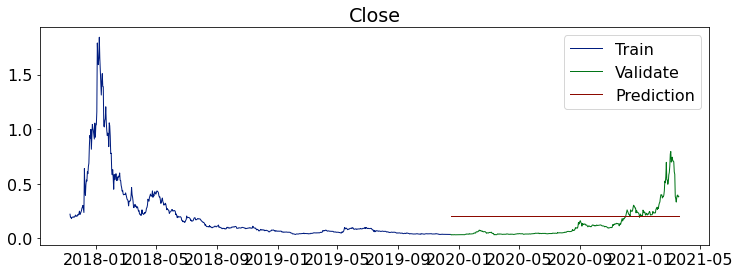

In [64]:
# plot actual vs predicted
plot_and_eval(nem_train, nem_validate, 'Close')

In [65]:
nem_train.columns

Index(['Close'], dtype='object')

In [66]:
# append metrics to evaluate dataframe
for col in nem_train.columns:
    eval_df = append_eval_df(model_type='nem_baseline_simple_average', validate_set=nem_validate,
                             target_var=col)
eval_df

,model_type,target_var,rmse
0,nem_baseline_simple_average,Close,0.1587


### For any model to be of value, it must beat the baseline RMSE

### Make predictions and evaluate using moving average

In [67]:
# First try 30 day rolling average and use the most recent/last 30 day period value to predict forward. 

close = round(nem_train.Close.rolling(30).mean().iloc[-1], 5)

# make predictions
yhat_df = pd.DataFrame({'Close': [close]}, index = nem_validate.index)

Close -- RMSE: 0.17151


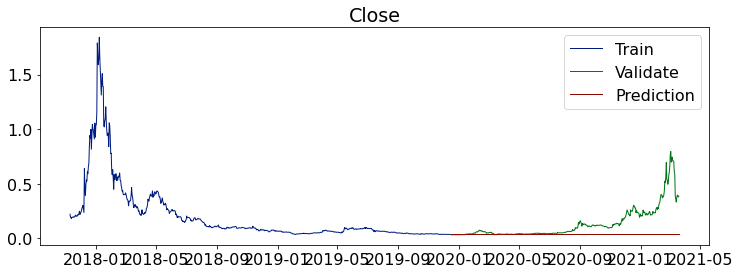

In [68]:
# plot actual vs predicted
plot_and_eval(nem_train, nem_validate, 'Close')

In [69]:
# append metrics to evaluate dataframe
for col in nem_train.columns:
    eval_df = append_eval_df(model_type='nem_30day_moving_avg', validate_set=nem_validate,
                             target_var=col)
eval_df

,model_type,target_var,rmse
0,nem_baseline_simple_average,Close,0.15870
1,nem_30day_moving_avg,Close,0.17151


In [70]:
# Next try 7 day rolling average and use the most recent/last 7 day period value to predict forward. 

close = round(nem_train.Close.rolling(7).mean().iloc[-1], 5)

# make predictions
yhat_df = pd.DataFrame({'Close': [close]}, index = nem_validate.index)

Close -- RMSE: 0.17233


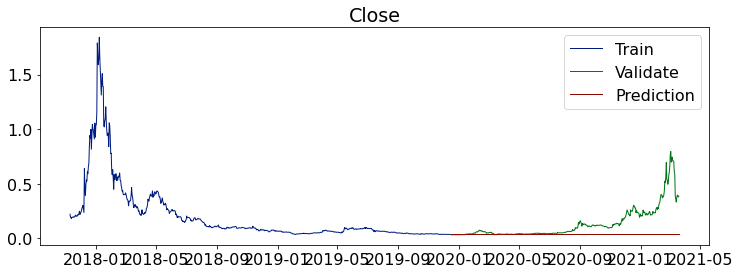

In [71]:
# plot actual vs predicted
plot_and_eval(nem_train, nem_validate, 'Close')

In [72]:
# append metrics to evaluate dataframe
for col in nem_train.columns:
    eval_df = append_eval_df(model_type='nem_7day_moving_avg', validate_set=nem_validate,
                             target_var=col)
eval_df

,model_type,target_var,rmse
0,nem_baseline_simple_average,Close,0.15870
1,nem_30day_moving_avg,Close,0.17151
2,nem_7day_moving_avg,Close,0.17233


In [73]:
# Next try 365 day rolling average and use the most recent/last 365 day period value to predict forward. 

close = round(nem_train.Close.rolling(365).mean().iloc[-1], 5)

# make predictions
yhat_df = pd.DataFrame({'Close': [close]}, index = nem_validate.index)

Close -- RMSE: 0.16129


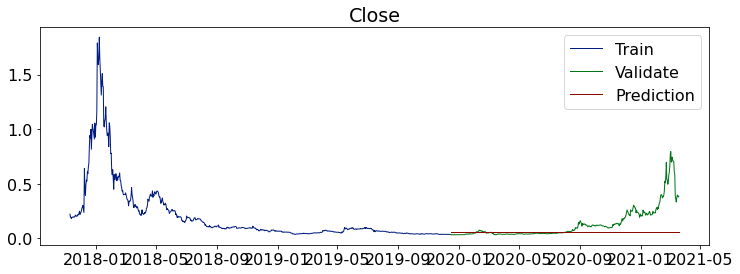

In [74]:
# plot actual vs predicted
plot_and_eval(nem_train, nem_validate, 'Close')

In [75]:
# append metrics to evaluate dataframe
for col in nem_train.columns:
    eval_df = append_eval_df(model_type='nem_365day_moving_avg', validate_set=nem_validate,
                             target_var=col)
eval_df

,model_type,target_var,rmse
0,nem_baseline_simple_average,Close,0.15870
1,nem_30day_moving_avg,Close,0.17151
2,nem_7day_moving_avg,Close,0.17233
3,nem_365day_moving_avg,Close,0.16129


### Make predictions and evaluate using Holt's Linear Trend

In [84]:
# create the model
close = Holt(nem_train.Close, exponential = False)
# fit the model
close = close.fit(smoothing_level = .2, smoothing_slope = .9, optimized = True)
# use the model to predict
yhat_df = pd.DataFrame(round(close.predict(start = nem_validate.index[0], end = nem_validate.index[-1]), 5), columns=['Close'])

In [85]:
yhat_df.head()

,Close
2019-12-16,0.03556
2019-12-17,0.03574
2019-12-18,0.03592
2019-12-19,0.03610
2019-12-20,0.03628


Close -- RMSE: 0.13713


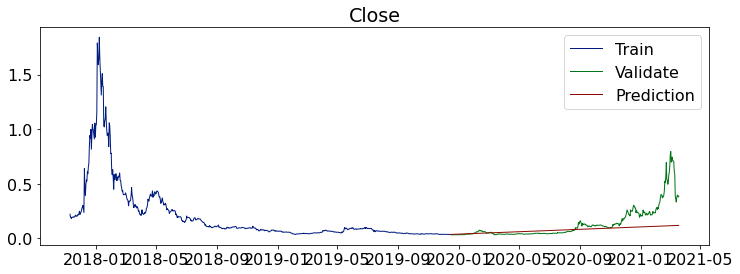

In [86]:
# plot actual vs predicted
plot_and_eval(nem_train, nem_validate, 'Close')

**I tried many different values for smoothing_level and smoothing_slope from 0 to 1 and .2 and .9, respectively, produced the best RMSE**

In [26]:
# append metrics to evaluate dataframe
for col in nem_train.columns:
    eval_df = append_eval_df(model_type='holts_linear_trend', validate_set=nem_validate,
                             target_var=col)
eval_df

,model_type,target_var,rmse
0,nem_baseline_simple_average,Close,0.15870
1,nem_30day_moving_avg,Close,0.17151
2,nem_7day_moving_avg,Close,0.17233
3,nem_365day_moving_avg,Close,0.16129
4,holts_linear_trend,Close,0.13713


### Make predictions and evaluate using ARIMA

In [27]:
p = d = q = range(0, 2)
pdq = list(it.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [28]:
# for param in pdq:
#     for param_model in model_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(nem_train,
#                                             order=param,
#                                             seasonal_order=param_model,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)
#             results = mod.fit()
#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_model, results.aic))
#         except:
#             continue

In [29]:
# create the model
model = ARIMA(nem_train.Close, order=(5,0,0))
# fit the model
model = model.fit()
# use the model to predict
yhat_items = model.predict(start = nem_validate.index[0], end = nem_validate.index[-1])
# add items to yhat df
yhat_df[col] = round(yhat_items, 5)

In [30]:
nem_validate.shape

(460, 1)

In [31]:
yhat_df.shape

(460, 1)

Close -- RMSE: 0.13104


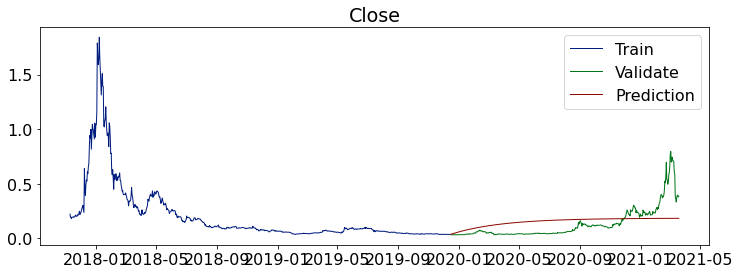

In [32]:
# plot actual vs predicted
plot_and_eval(nem_train, nem_validate, 'Close')

In [33]:
# append metrics to evaluate dataframe
for col in nem_train.columns:
    eval_df = append_eval_df(model_type='ARIMA', validate_set=nem_validate,
                             target_var=col)
eval_df

,model_type,target_var,rmse
0,nem_baseline_simple_average,Close,0.15870
1,nem_30day_moving_avg,Close,0.17151
2,nem_7day_moving_avg,Close,0.17233
3,nem_365day_moving_avg,Close,0.16129
4,holts_linear_trend,Close,0.13713
5,ARIMA,Close,0.13104


<AxesSubplot:xlabel='Date'>

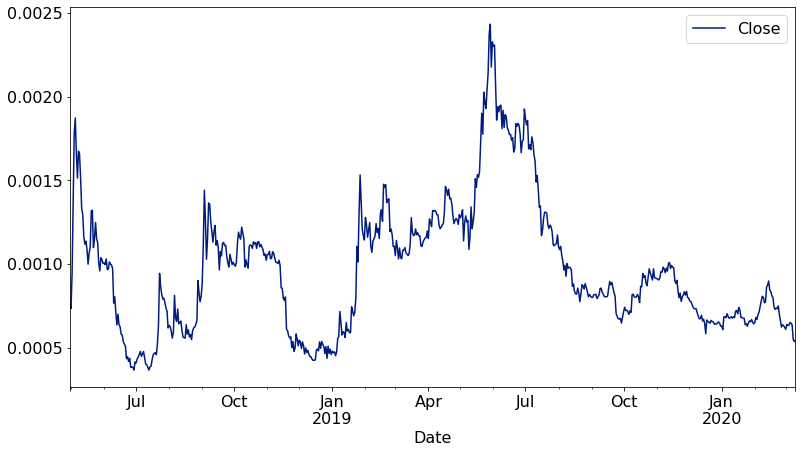

In [34]:
# plot data
holo_train.plot()

In [35]:
# predict using mean for all train data
close = holo_train.Close.mean()

yhat_df = pd.DataFrame({'Close': [close]}, index = holo_validate.index)

Close -- RMSE: 0.00489


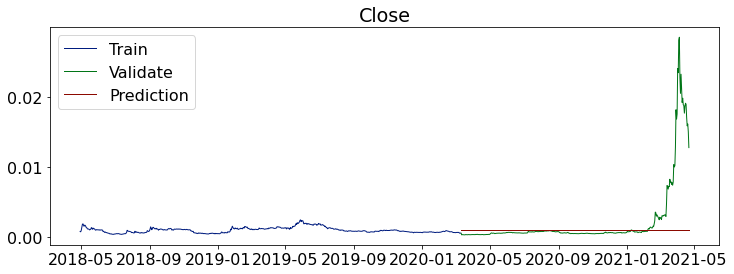

In [36]:
# plot actual vs predicted
plot_and_eval(holo_train, holo_validate, 'Close')

In [37]:
# append metrics to evaluate dataframe
for col in holo_train.columns:
    eval_df = append_eval_df(model_type='holo_baseline_simple_average', validate_set=holo_validate,
                             target_var=col)
eval_df

,model_type,target_var,rmse
0,nem_baseline_simple_average,Close,0.15870
1,nem_30day_moving_avg,Close,0.17151
2,nem_7day_moving_avg,Close,0.17233
3,nem_365day_moving_avg,Close,0.16129
4,holts_linear_trend,Close,0.13713
5,ARIMA,Close,0.13104
6,holo_baseline_simple_average,Close,0.00489
